In [ ]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from tensorflow.keras.layers import *
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.xception import Xception
import pandas as pd
import shutil


In [ ]:
import kagglehub
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)
print("Files and folders:", os.listdir(path))

Path to dataset files: /kaggle/input/massachusetts-roads-dataset
Files and folders: ['label_class_dict.csv', 'tiff', 'metadata.csv']


In [ ]:
os.makedirs("/kaggle/working/train/images", exist_ok=True)
os.makedirs("/kaggle/working/train_labels/masks", exist_ok=True)

for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/train"):
    if file.endswith(".tiff"):
        shutil.copy(f"/kaggle/input/massachusetts-roads-dataset/tiff/train/{file}",
                    f"/kaggle/working/train/images/{file}")

for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/train_labels"):
    if file.endswith(".tif"):
        shutil.copy(f"/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/{file}",
                    f"/kaggle/working/train_labels/masks/{file}")

os.makedirs("/kaggle/working/val/images", exist_ok=True)
os.makedirs("/kaggle/working/val_labels/masks", exist_ok=True)
for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/val"):
    if file.endswith(".tiff"):
        shutil.copy("/kaggle/input/massachusetts-roads-dataset/tiff/val/" + file,
                    "/kaggle/working/val/images/" + file)

for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/val_labels"):
    if file.endswith(".tif"):
        shutil.copy("/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/" + file,
                    "/kaggle/working/val_labels/masks/" + file)


In [ ]:
os.makedirs("/kaggle/working/train/images/road", exist_ok=True)
os.makedirs("/kaggle/working/train_labels/masks/road", exist_ok=True)
os.makedirs("/kaggle/working/val/images/road", exist_ok=True)
os.makedirs("/kaggle/working/val_labels/masks/road", exist_ok=True)

source_train_images = "/kaggle/working/train/images"
dest_train_images = "/kaggle/working/train/images/road"
for file in os.listdir(source_train_images):
    if file.endswith(".tiff"):
        shutil.move(os.path.join(source_train_images, file), os.path.join(dest_train_images, file))

source_train_masks = "/kaggle/working/train_labels/masks"
dest_train_masks = "/kaggle/working/train_labels/masks/road"
for file in os.listdir(source_train_masks):
    if file.endswith(".tif"):
        shutil.move(os.path.join(source_train_masks, file), os.path.join(dest_train_masks, file))

source_val_images = "/kaggle/working/val/images"
dest_val_images = "/kaggle/working/val/images/road"
for file in os.listdir(source_val_images):
    if file.endswith(".tiff"):
        shutil.move(os.path.join(source_val_images, file), os.path.join(dest_val_images, file))

source_val_masks = "/kaggle/working/val_labels/masks"
dest_val_masks = "/kaggle/working/val_labels/masks/road"
for file in os.listdir(source_val_masks):
    if file.endswith(".tif"):
        shutil.move(os.path.join(source_val_masks, file), os.path.join(dest_val_masks, file))

print("Directory structure reorganized for flow_from_directory.")

Directory structure reorganized for flow_from_directory.


In [ ]:
import tensorflow as tf
import os

train_images_dir = "/kaggle/working/train/images/road"
train_masks_dir = "/kaggle/working/train_labels/masks/road"

val_images_dir = "/kaggle/working/val/images/road"
val_masks_dir = "/kaggle/working/val_labels/masks/road"

train_image_paths = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if f.endswith(".tiff")])
train_mask_paths = sorted([os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir) if f.endswith(".tif")])

val_image_paths = sorted([os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith(".tiff")])
val_mask_paths = sorted([os.path.join(val_masks_dir, f) for f in os.listdir(val_masks_dir) if f.endswith(".tif")])

print(f"Training images: {len(train_image_paths)}")
print(f"Training masks: {len(train_mask_paths)}")
print(f"Validation images: {len(val_image_paths)}")
print(f"Validation masks: {len(val_mask_paths)}")

Training images: 1108
Training masks: 1108
Validation images: 14
Validation masks: 14


In [ ]:
!pip install tensorflow-io


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.0 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import tensorflow as tf
import numpy as np

IMG_SIZE = 256
BATCH_SIZE = 16
BUFFER_SIZE = 1000

def process_path(image_path, mask_path):
    image = Image.open(image_path.numpy().decode())
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image) / 255.0
    if image.ndim == 2:  # grayscale to RGB
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] == 4:  # RGBA to RGB
        image = image[..., :3]
    image = image.astype(np.float32)

    mask = Image.open(mask_path.numpy().decode())
    mask = mask.resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
    mask = np.array(mask)
    mask = (mask > 0).astype(np.float32)
    if mask.ndim == 3:
        mask = mask[..., 0]  # if mask has channel dim, take one channel

    return image, mask

def tf_process_path(image_path, mask_path):
    image, mask = tf.py_function(process_path, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    mask.set_shape([IMG_SIZE, IMG_SIZE])
    return image, mask

def load_dataset(image_paths, mask_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(tf_process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = load_dataset(train_image_paths, train_mask_paths)
val_dataset = load_dataset(val_image_paths, val_mask_paths)

for images, masks in train_dataset.take(1):
    print(images.shape)
    print(masks.shape)


(16, 256, 256, 3)
(16, 256, 256)


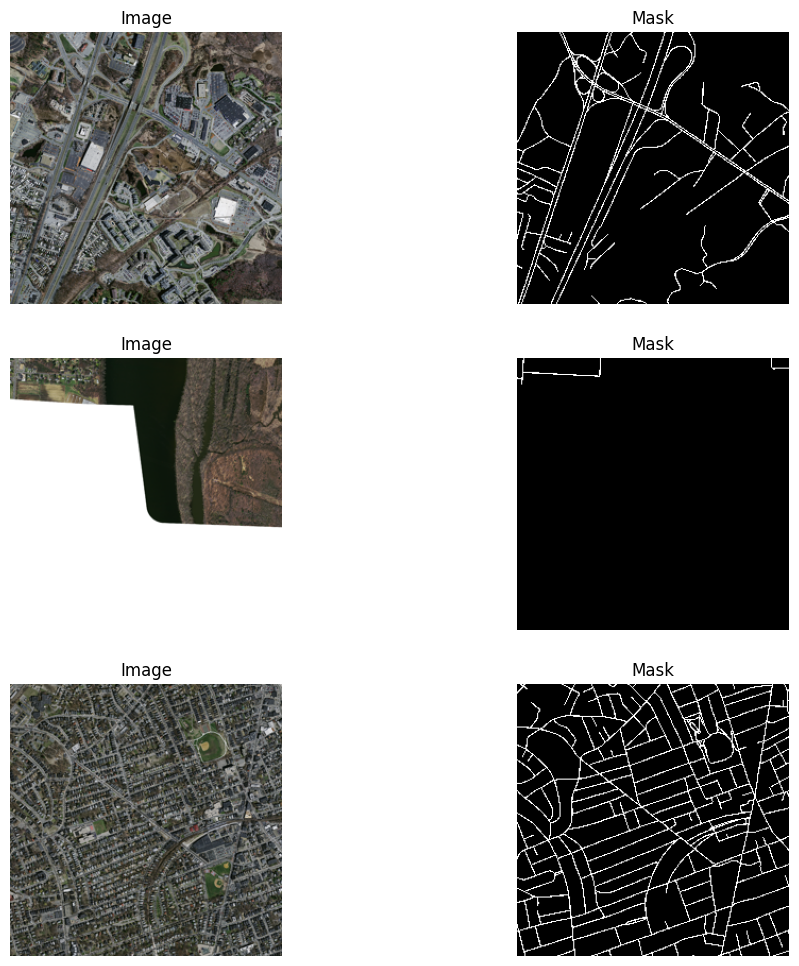

In [ ]:
import matplotlib.pyplot as plt

def display_samples(dataset, n=3):
    for images, masks in dataset.take(1):
        plt.figure(figsize=(12, n * 4))
        for i in range(n):
            plt.subplot(n, 2, 2*i + 1)
            plt.imshow(images[i])
            plt.title("Image")
            plt.axis('off')

            plt.subplot(n, 2, 2*i + 2)
            plt.imshow(masks[i], cmap='gray')
            plt.title("Mask")
            plt.axis('off')
        plt.show()

display_samples(train_dataset, n=3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D()(c4)

    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model

model = unet_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset
)


Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.6992 - loss: 0.6579 - val_accuracy: 0.9310 - val_loss: 0.3782
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 133s 880ms/step - accuracy: 0.9468 - loss: 0.3338 - val_accuracy: 0.9310 - val_loss: 0.2526
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 877ms/step - accuracy: 0.9581 - loss: 0.1807 - val_accuracy: 0.9310 - val_loss: 0.2669
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 884ms/step - accuracy: 0.9612 - loss: 0.1344 - val_accuracy: 0.9310 - val_loss: 0.3254
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 143s 903ms/step - accuracy: 0.9653 - loss: 0.1139 - val_accuracy: 0.9310 - val_loss: 0.3249
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 140s 878ms/step - accuracy: 0.9647 - loss: 0.1116 - val_accuracy: 0.9310 - val_loss: 0.3535
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 143s 885ms/step - accuracy: 0.9662 - loss: 0.1062 - val_accuracy: 0.9310 - val_loss: 0.3521
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 121s 885ms/step - accuracy: 0.9686 - loss: 0.0978 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9606 - loss: 0.1070
Validation Loss: 0.1070
Validation Accuracy: 0.9606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Mean IoU on Validation Dataset: 0.4655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


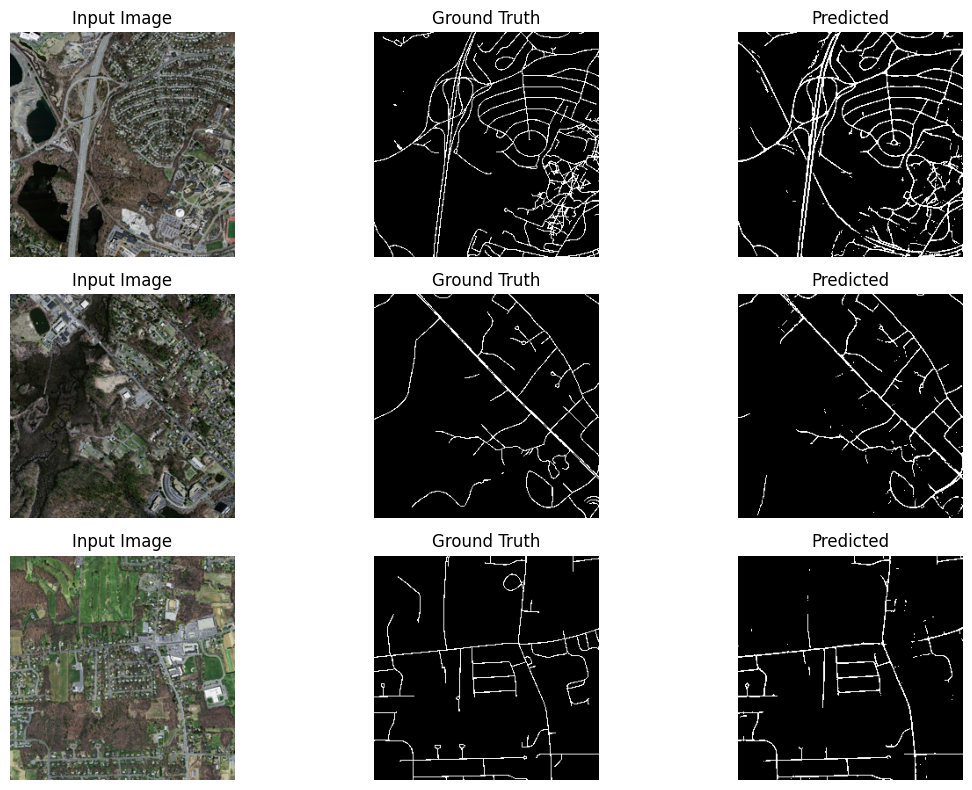

In [ ]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

num_classes = 2
def compute_mean_iou(model, dataset):
    iou_scores = []
    for images, masks in dataset:
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1)
        preds = tf.cast(preds, tf.int32)
        masks = tf.cast(masks, tf.int32)
        if masks.shape[-1] == 1:
            masks = tf.squeeze(masks, axis=-1)
        iou = tf.keras.metrics.MeanIoU(num_classes=num_classes)
        iou.update_state(masks, preds)
        iou_scores.append(iou.result().numpy())
    return np.mean(iou_scores)

mean_iou = compute_mean_iou(model, val_dataset)
print(f"Mean IoU on Validation Dataset: {mean_iou:.4f}")

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

for images, masks in val_dataset.take(1):
    preds = model.predict(images)

    if preds.shape[-1] > 1:
        pred_prob = preds[..., 1]
    else:
        pred_prob = preds[..., 0]

    pred_mask_thresh = np.where(pred_prob > 0.19, 255, 0).astype(np.uint8)

    plt.figure(figsize=(12, 8))
    for i in range(min(3, images.shape[0])):
        img = images[i].numpy()
        if img.max() <= 1.0:
            img_disp = (img * 255).astype(np.uint8)
        else:
            img_disp = img.astype(np.uint8)

        plt.subplot(3, 3, i*3 + 1)
        if img_disp.shape[-1] == 1:
            plt.imshow(np.squeeze(img_disp), cmap='gray')
        else:
            plt.imshow(img_disp)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(3, 3, i*3 + 2)
        mask = masks[i].numpy()
        if mask.shape[-1] == 1:
            mask = np.squeeze(mask, axis=-1)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(pred_mask_thresh[i], cmap='gray')
        plt.title("Predicted")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
